<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/Milestone_Project_2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit
The purpose of this notebook is to build an NLP model to make reading medical abstracts easier. 

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order. In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

### What we're going to cover
Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:
- Downloading a text dataset (PubMed RCT200k from GitHub)
- Writing a preprocessing function to prepare our data for modelling
- Setting up a series of modelling experiments
  - Making a baseline (TF-IDF classifier)
  - Deep models with different combinations of: token  embeddings, character embeddings, pretrained embeddings, positional embeddings
- Building our first multimodal model (taking multiple types of data inputs).
  - Replicating the model architecture from [paper](https://arxiv.org/pdf/1612.05251.pdf)
- Find the most wrong predictions
- Making predictions on PubMed abstracts from the wild

### Get Data 
Let's download the PubMed 200k PCT data. 
https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md



Checking the contents of the downloaded repository, you can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the README file from the GitHub page, we get the following information:


- PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
- PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. - PubMed_20k_RCT_numbers_replaced_with_at_sign).
- Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with @ but we didn't.
Let's check the file contents.

- Paper for Modelling : https://arxiv.org/abs/1612.05251
- Application paper: https://arxiv.org/abs/1710.06071

**Problem in a sentence**

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**Solution in a sentence**

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

In [ ]:
# Check what files are in the PubMed_20k dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# # Start our experiments using thhe 20K dataset with numbers replaced by '@' sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# Check all of the filenames in the target direcotry 
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data 

Now we've got some text data, it's time to become one with it. 
And one of the best ways to become one with the data is to... 

> Visualize , Visualize , visualize....

So with that in mind, lets write a function to read in all of the lines of a target text file. 

In [ ]:
# Create function to read the lines of a document 
def get_lines(filename):
  '''
  Reads filename (a text filename) adn returns the line of text as a list. 

  Args: 
    filename: a string containing the target filepth 

 Returns: 
  A list of stings with one string per line from the target filename
  '''
  with open(filename , 'r') as f: 
    return f.readlines()

In [ ]:
# Using our function , lets read in training lines 
train_lines = get_lines(data_dir + 'train.txt') # read the lines within the training file 
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We can't pass this train lines straight into our model because they are quite messy and our model will start to learning something irrelavant. 

But we can turn this lines into our desired way from which our model can learn. 
- Every new abstract starts with a **###somenumbers** so we can differentiate between different abstracts through this.
- And every label is at the starting line of the sentence, for instance **OBJECTIVE , METHODS** these are present at the very starting line of a sentence.
- Each abstract ends with an **\n** new line command.


Lets think about how we want our data to look...

How the data would be best represented? 

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```


In [ ]:
# Number of lines 
len(train_lines)

210040

Let's write a function to perform the following steps:

- Take a target file of abstract samples.
- Read the lines in the target file.
- For each line in the target file:
  - If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
    - Keep count of the number of lines in a sample.
  - If the line begins with \n mark it as the end of an abstract sample.
    - Keep count of the total lines in a sample.
  - Record the text before the \t as the label of the line.
  - Record the text after the \t as the text of the line.
- Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
- "line_number" - the position of the line in the abstract (e.g. 3).
- "target" - the role of the line in the abstract (e.g. OBJECTIVE).
- "text" - the text of the line in the abstract.
- "total_lines" - the total lines in an abstract sample (e.g. 14).
- Abstract ID's and newlines should be omitted from the returned preprocessed data.


Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples

In [ ]:
# Using the above function on our data samples
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 561 ms, sys: 108 ms, total: 669 ms
Wall time: 680 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]


[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
# Turning our dictionary into a DataFrame for better visualization
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distributions of labels (checking the balance spread of our labels)
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

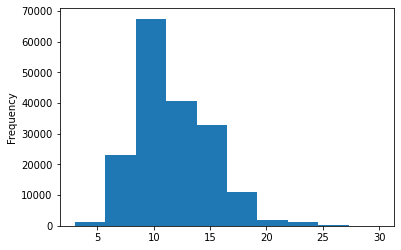

In [ ]:
# Distribution of our abstract length (spread of the abstract lines)
train_df.total_lines.plot.hist()

It looks like most of the abstracts are around 7 to 15 sentences in length. 

### Get a list of sentences 

While building a model the main inputs will be a list of strings (the line of the abstract). 

Lets get that lines from our dataframe by calling `tolist()`.

In [ ]:
# Convert abstract text lines from df to a lists 
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

# Printing the shapes of the sentences 
print(len(train_sentences) , len(val_sentences) , len(test_sentences) )

180040 30212 30135


In [ ]:
# View the first 10 lines of the training sentences 
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric Labels (convert our labels into numbers) 

We will be building two types of methods: 
- One hot encoding --> For the TensorFlow 
- Label Encoder --> For the Baseline (w/o tensorflow)

In [ ]:
# One hot encode labels 
from sklearn.preprocessing import OneHotEncoder

# Instantiating as a method 
one_hot_encoder = OneHotEncoder(sparse = False)

# Performing One hot encoding to our labels 
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1 , 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1 , 1))

# Checking the length 
print(len(train_labels_one_hot) , len(val_labels_one_hot) , len(test_labels_one_hot))

180040 30212 30135


In [ ]:
# Checking a example of our. train labels one hot encoded 
train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Label encode labels

In [ ]:
# Extract labels ('target' columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder

# Instantiating a method 
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check how the training labels looks like 
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

A great functionality of `LabelEncoder` is we can get the class names and number of classes using the `classes_attribute`.

In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_


# Looking inside how it looks like
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## **Creating a series of model experiments**

We've preprocessed our data, so the next step would be performing some series of modelling experiments. 

At first like always let's build a baseline model and obtain a score from that. Then we'll try to beast that score by building more and more complex models. 

For each model, we'll train it on the training data and evaluate on the validation data.

### Model 0: Getting a baseline 

Our first model will be a TF-IDF Multinomial Naive Bayes. For this we will create a Scikit-learn Pipeline which uses the `TfidVectorizer` class to convert our abstract sentences to number using the **TF-IDF** algorithm and then learns to classify our sentences using the `MultiNomial` algorithm. 

In [ ]:
# Building a sklearn Pipeline for our baseline model 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a pipeline 
model_0 = Pipeline([
  ('tf-idf', TfidfVectorizer()), 
  ('clf' , MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences , 
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluating our baseline model on the validation data 
model_0.score(X = val_sentences, 
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
# Making predictions on the val sentences
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Creating a function to calculate the evaluation metircs 

def calculate_metrics(y_true , y_preds):
  '''
  Arguments: 
  y_true --> true labels of the data 
  y_preds --> predicted labels of the data 

  Returns: 
  A dictionary of evaluation metrics like precision , recall and f1_score
  '''

  # Let's first import the needed metrics 
  from sklearn.metrics import precision_score , f1_score , accuracy_score , recall_score

  # Creting the metrics 
  accuracy = accuracy_score(y_true , y_preds)
  f1_score = f1_score(y_true , y_preds , average = 'weighted')
  precision = precision_score(y_true , y_preds , average = 'weighted')
  recall = recall_score(y_true , y_preds , average = 'weighted')

  # Now will create a dictionary of these metrics and pack them
  evaluation_dict = {'Accuracy:': accuracy * 100 , 
                     'F1_Score: ': f1_score , 
                     'Precision: ': precision , 
                     'Recall: ': recall }

  # Return our dictionary 
  return evaluation_dict

`macro` --> Insensitive to the label imabalance 
`micro` --> takes in account of the fp,fn etc.. 


In [ ]:
# Getting the evaluation metrics dict for our model 
baseline_results = calculate_metrics(val_labels_encoded , baseline_preds)
baseline_results

{'Accuracy:': 72.1832384482987,
 'F1_Score: ': 0.6989250353450294,
 'Precision: ': 0.7186466952323352,
 'Recall: ': 0.7218323844829869}

Thats great! We got our baseline results now lets do some more preprocessing works on our data so we can build a deep sequence model with it. 

## Preparing our data for deep sequence models 

Before we start building deep models we gotta create vectorization and Embedding layers. 

In [ ]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras import layers 

Before jumping into the modelling we have to do some analysis on our data so that it will be quite appropriate for us to converting our text into numbers. 

Its a good idea to figure out how many words are in each sentence. Because when our model goes through our sentences, it **works best when they're all at the same length (crucial for creating batches).** 

> For example, if one sentence is eight words long and another in 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence. 

In [ ]:
# How long is each sentence on average? (spread of sentence len)
sent_lens = [len(sentence.split()) for sentence in train_sentences]

# Taking average of the sentence lens 
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

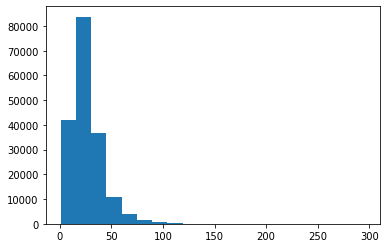

In [ ]:
# Whats the distribution look like? 
import matplotlib.pyplot as plt
plt.hist(sent_lens , bins = 20)

Our vast majority of sentence lengths are between 0 to 50 tokens in length. It would be ideal if we pad all the sentences to 50. 

Lets see in % to find the value which covers 95% of the sentence lengths. 

In [ ]:
# How long a sentence covers 95% of the lengths? 
output_seq_len = int(np.percentile(sent_lens , 95))
output_seq_len

55

It seems the 95% of the sentences in our training set have a length of 55 tokens or less. 

When we create our tokenization layer, we will use this value to turn all our sentences into the same length. 

That means sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated. 

In [ ]:
# Maximum seq lenght in our training set 
max(sent_lens) # Something is 296 words long 

296

#### Create a text vectorizer layer 
Now we got some infos abour our data we can now turn our text into numbers.

The first step we would do is turning our texts into tokens by using the text_vectorizer layer from TensorFlow. 

In [ ]:
# Creating a text vectorizer layer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Variables for our text vectorizer layer 
max_vocab = 68000 # from the paper (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)

# Creating the layer 
text_vectorizer = TextVectorization(max_tokens= max_vocab , 
                                    output_sequence_length = output_seq_len , 
                                    output_mode = 'int')

# Calling the adapt method on our train sentences so our inherits the texts 
text_vectorizer.adapt(train_sentences)

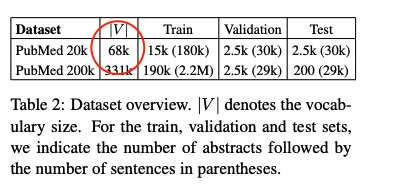

In [ ]:
# Looking into our test vectorizer 
import random 
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text:\n {text_vectorizer([target_sentence])}')

Text:
 harmonic dissection yielded better outcomes compared to electrocautery with lower estimated blood loss ( @ @ vs. @ @ , p < @ ) , less drain volume ( @ @ ml vs. @ @ ml , p < @ ) , fewer drain days ( @ @ vs. @ @ , p < @ ) , less seroma formation ( @ vs. @ % , p = @ ) , and less postoperative pain -lsb- median ( interquartile range ) @ ( @-@ ) vs. @ ( @-@ ) , p < @ -rsb- , whereas mean operative time ( @ @ vs. @ @ min , p = @ ) and ssi ( @ vs. @ % , p = @ ) did not differ .

Length of text: 128

Vectorized text:
 [[7691 2756 2392  252   75   34    6 7374    7  105  597  107  264   44
    14  211 3483  326  364   44  364   14  704 3483   84   44   14  211
  5324 1931   44   14    3  211  163   65   46  193 1521  283   44   14
    45  436   57 1216   63   44  242   14    3 4011   44   14  112]]


In [ ]:
# How many words in our training vocabulary 
rct_20k_text_vocab = text_vectorizer.get_vocabulary() 

# Printing the top 5 and least 5 
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Configuratio of our Text vectorizer 
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization_2',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

#### Create a custom text embedding 

Out `text_vectorization` helps to map the words in our text directly to numbers but yet it doesn't necessarily caputre the relationships between those numbers. 

We use **embedding**, to create a richer numerical representation of our text. 

As our model learns by going through the test, it will update its embedding to better represent the relationships betwen the tokens in our corpus (vocab).

The main parameter we're concerned here is the input_dim and output_dim of our Embedding layer. 

- `input_dim` --> defines the size of our vocabulary 
- `output_dim` --> defines the dimensions of the embedding output. 

Our embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size `output_dim`

**Links**: 
- https://stackoverflow.com/questions/47485216/how-does-mask-zero-in-keras-embedding-layer-work/61102319#61102319
- https://www.tensorflow.org/guide/keras/masking_and_padding

In [ ]:
# Create a token embedding layer 
token_embed = layers.Embedding(input_dim= len(rct_20k_text_vocab) , 
                               output_dim = 128  , # different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero = True, 
                               name ='token_embedding')

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
harmonic dissection yielded better outcomes compared to electrocautery with lower estimated blood loss ( @ @ vs. @ @ , p < @ ) , less drain volume ( @ @ ml vs. @ @ ml , p < @ ) , fewer drain days ( @ @ vs. @ @ , p < @ ) , less seroma formation ( @ vs. @ % , p = @ ) , and less postoperative pain -lsb- median ( interquartile range ) @ ( @-@ ) vs. @ ( @-@ ) , p < @ -rsb- , whereas mean operative time ( @ @ vs. @ @ min , p = @ ) and ssi ( @ vs. @ % , p = @ ) did not differ .

Sentence after vectorization (before embedding):
[[7691 2756 2392  252   75   34    6 7374    7  105  597  107  264   44
    14  211 3483  326  364   44  364   14  704 3483   84   44   14  211
  5324 1931   44   14    3  211  163   65   46  193 1521  283   44   14
    45  436   57 1216   63   44  242   14    3 4011   44   14  112]]

Sentence after embedding:
[[[ 0.04608295  0.03181722  0.02956503 ... -0.00966995  0.0206647
    0.03075958]
  [ 0.0412221   0.04581087 -0.04744446 ...  0.041

Our each vector will be the size of 128 long vectors. 

#### Create datasets (as fast as possible) 

Now its time to pack our texts into datasets to be used with a ml model, now we will look into some methods to make the process faster. 

- We will use a `PrefetchDataset` of batches (will use prefetch). Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, so faster training time. 
- We will use `batch()` and `prefetch()`and `tf.data.AutoTune` will help us to determine optimal amount of compute to use to prepare datasets. 

In [ ]:
# Turn our data into TensorFlow Datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))

# Looking into our train dataset 
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Applying batch and prefetch on our dataset 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings 

So far we got everything we needed to model our data. Our deep models will follow a similar structure: 

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```
We will be changing some Layers components, because the modern deep NLP models requires text to be converted into embedding before meaningful patterns can be discovered within. 

The first model we're going to build is a 1-dimensional Convolutional Neural Networks. And we will follow the below workflow: 
- Build Model 
- Train Model 
- Evaluate model (make preds and compare with the ground truth). 

In [87]:
# Building the Conv1D model to process sequences 
inputs = layers.Input(shape = (1, ),  dtype= tf.string)

# Preprocessing layers 
text_vectors = text_vectorizer(inputs) # vectorize text inputs 
token_embeddings = token_embed(text_vectors) # create embedding 

# Conv1D layer 
x = layers.Conv1D(filters= 64 , kernel_size= 5 , padding= 'same' , activation= 'relu')(token_embeddings)
x = layers.GlobalMaxPooling1D()(x) # condense the output of our feature vector(patterns learned by our model)

# output layer 
outputs = layers.Dense(num_classes , activation= 'softmax')(x)

# Packing into a model 
model_1 = tf.keras.Model(inputs , outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy() , # because of one hot encoded labels
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])


# Summary of our model 
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

By looking at the model summary we can notice the majority of the trainable parameters are within the embedding layer. And if we're to increase the size of the embedding layer (output_dim) the number of trainable parameters would increase dramatically. 

We will use only the first 10% of batches (about 18k samples) of the training set to train and first 10% of batches from the validation set to validate on. 

> **🔑 Note:** It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. You should aim to run many smaller experiments rather than only a handful of large experiments. And since your time is limited, one of the best ways to run smaller experiments is to reduce the amount of data you're working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

We are conduction experiments on our data so we train only on 10% of the data. This is to ensure we speed up our experimentation. 

In [98]:
int(0.1 * len(train_dataset)) * 32 # Num of samples

17984

In [89]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 59s 103ms/step - loss: 0.8221 - accuracy: 0.6912 - val_loss: 0.5865 - val_accuracy: 0.7793
Epoch 2/3
562/562 [==============================] - 57s 102ms/step - loss: 0.5805 - accuracy: 0.7866 - val_loss: 0.5426 - val_accuracy: 0.8009
Epoch 3/3
562/562 [==============================] - 57s 101ms/step - loss: 0.5468 - accuracy: 0.7979 - val_loss: 0.5224 - val_accuracy: 0.8049


In [90]:
# Evaluate the model on a whole validation dataset 
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.5220 - accuracy: 0.8062


[0.521992564201355, 0.8061697483062744]

In [96]:
# Make predictions (our model outputs prediction probabilties for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[6.1249566e-01, 5.0017785e-02, 1.2031391e-03, 3.3473432e-01,
        1.5490730e-03],
       [3.2144207e-01, 4.9921387e-01, 2.8989129e-03, 1.7237091e-01,
        4.0741889e-03],
       [1.7884278e-01, 4.9045412e-03, 2.3070378e-03, 8.1376898e-01,
        1.7660666e-04],
       ...,
       [1.9383601e-04, 1.9397850e-03, 2.5724567e-02, 1.6585793e-04,
        9.7197592e-01],
       [2.5381109e-02, 2.9809108e-01, 3.5480879e-02, 2.3255002e-02,
        6.1779189e-01],
       [3.1883635e-02, 9.5560461e-01, 3.0067882e-03, 3.1053110e-03,
        6.3996580e-03]], dtype=float32)

In [97]:
# Converting our pred probs to class preds 
model_1_preds = tf.argmax(model_1_pred_probs , axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [100]:
# Calculate the model 1 results 
model_1_results = calculate_metrics(val_labels_encoded , 
                                    model_1_preds)
model_1_results

{'Accuracy:': 80.61697338805772,
 'F1_Score: ': 0.8041872143530673,
 'Precision: ': 0.8038125441096377,
 'Recall: ': 0.8061697338805772}

In [101]:
baseline_results

{'Accuracy:': 72.1832384482987,
 'F1_Score: ': 0.6989250353450294,
 'Precision: ': 0.7186466952323352,
 'Recall: ': 0.7218323844829869}

### Model 2: Feature extraction with pretrained token embeddings 

Rather using a Conv1D model let's use a pretrained token embedding from the Tensorflow Hub. 

The model structure will look like this: 

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

> **🔑 Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.


But we dont have a Glove embedding in our TensorFlow Hub, so we will go with our universal  
[sentence encoder layer](https://tfhub.dev/google/universal-sentence-encoder/4) as our pretrained token embedding 

In [104]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub 
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4' , 
                                        trainable = False , 
                                        name = 'universal_sentence_encoder')

In [105]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
to assess efficacy and safety of lixisenatide once-daily versus placebo in type @ diabetes mellitus ( t@dm ) patients inadequately controlled on sulfonylurea ( su ) metformin .

Sentence after embedding:
[ 0.02635027 -0.05228478 -0.03472503 -0.03141569  0.00064189  0.02912895
 -0.06614345 -0.04045834  0.00481357  0.018817    0.07683027 -0.06321398
  0.03047598  0.04579177 -0.04374629 -0.03262419 -0.07693796 -0.04200216
 -0.05257654  0.00819501  0.06093007  0.03953037  0.02442538 -0.05653007
  0.06417734  0.00906013  0.0451041   0.05417657 -0.01227856 -0.01259714] (truncated output)...

Length of sentence embedding:
512


USE module (pretrained embedding) takes care of tokenizing our text for us and outputs 512 dim embedding vector. 

Now lets build a model with our pretrained embedding layer. 

In [108]:
# Building our model with the feature extraction layer 
inputs = layers.Input(shape = [] , dtype= tf.string)

# Our pretrained embedding layer 
pretrained_embedding = tf_hub_embedding_layer(inputs)

# FC layer 
x = layers.Dense(128 , activation = 'relu')(pretrained_embedding)
outputs = layers.Dense(num_classes , activation= 'softmax')(x)

# Packing into a model 
model_2 = tf.keras.Model(inputs , outputs)

# Compile the model 
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])

# Sumamry of the model 
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [109]:
# Fit the feature extractor model for 3 epochs 
model_2_history = model_2.fit(train_dataset , 
                              epochs = 3 , 
                              steps_per_epoch = int(0.1 * len(train_dataset)) , 
                              validation_data = valid_dataset , 
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 0.9156 - accuracy: 0.6495 - val_loss: 0.8001 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7718 - accuracy: 0.7005 - val_loss: 0.7587 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7568 - accuracy: 0.7109 - val_loss: 0.7433 - val_accuracy: 0.7104


In [110]:
# Evaluating our model on the whole valid data 
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7453 - accuracy: 0.7109


[0.7452786564826965, 0.7109426856040955]

In [111]:
# Make predictions with our feature extraction model 
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.4198316e-01, 3.4378499e-01, 2.7465692e-03, 2.0457564e-01,
        6.9097024e-03],
       [3.1368777e-01, 5.3439915e-01, 4.8623034e-03, 1.4488553e-01,
        2.1652456e-03],
       [2.4825108e-01, 1.5527861e-01, 2.4195034e-02, 5.3953093e-01,
        3.2744419e-02],
       ...,
       [1.7741235e-03, 6.3353018e-03, 5.2916419e-02, 9.3344296e-04,
        9.3804067e-01],
       [3.9784648e-03, 4.5391664e-02, 1.9019949e-01, 1.4154935e-03,
        7.5901484e-01],
       [2.0162354e-01, 2.9017770e-01, 4.4618252e-01, 7.0488988e-03,
        5.4967288e-02]], dtype=float32)

In [112]:
# Convert the pred probs to class preds 
model_2_preds = tf.argmax(model_2_pred_probs , axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [113]:
# Results for our feature extraction model 
model_2_results = calculate_metrics(val_labels_encoded , 
                                    model_2_preds)
model_2_results

{'Accuracy:': 71.09426717860453,
 'F1_Score: ': 0.7079139621512185,
 'Precision: ': 0.7119554040391881,
 'Recall: ': 0.7109426717860453}